# ML — SVR Modeling (Clean Data Template)


Purpose
-------
Prepare cleaned, model-ready car-pricing data and evaluate Support Vector Regression baselines using the project's preprocessing utilities and feature-selection procedures.



Datasets used
--------------
- `Data/train.csv` — labeled training data
- `Data/test.csv` — unlabeled test data (used for final submission workflows)
- External vehicle models (downloaded from Kaggle: `vehicle models.json`)



Expected outputs
----------------
- A fitted `DataPreprocessor` instance for reproducible transforms
- A concise selected feature list (from feature-selection steps)
- Trained baseline models (SVR and optionally others) and saved model artifacts (pickle/joblib)
- Evaluation metrics: RMSE, MAE, R² (table)
- Diagnostic figures: predicted vs true, residuals, error distribution
- Optional: a submission CSV ready for Kaggle

## Table of Contents
- [Environment & Imports](#Environment--Imports)  
- [Data Loading](#Data-Loading)
- [Preprocessing Pipeline](#Preprocessing-Pipeline)  
- [Feature Engineering & Selection](#Feature-Engineering-&-Selection)
- [Train / Validation / Test Splits](#Train-/-Validation-/-Test-splits)
- [Model Definition & Training](#Model-Definition-&-Training)
- [Hyperparameter Search](#Hyperparameter-Search)
- [Model Evaluation & Diagnostics](#Model-Evaluation-&-Diagnostics)
- [Final Predictions & Submission](#Final-Predictions-&-Submission)
- [Conclusions & Next Steps](#Conclusions-&-Next-Steps)
- [Appendix & Utilities](#Appendix-&-Utilities)

## Data Loading
Load the primary datasets into pandas DataFrames and run a very short inspection (shape, dtypes, top rows, and missing-value counts). Keep heavy EDA in a separate notebook to keep this file concise.

In [50]:
import pandas as pd
import numpy as np
import os
import json
import kagglehub
import warnings
import traceback
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import itertools
import random

# Load preprocessing classes
os.chdir('H:\Mestrado\Mlearn2\ML_group_45-main')  # Change to project root directory
# Preprocessing and utility imports
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper



print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)


param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


# CONFIGURATION - Change these as needed
CONFIG = {

    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'onehot',        # 'mean', 'onehot'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
    
    # Data splitting
    'test_size': 0.2,                 # Proportion of data for testing
    'feature_selection_size': 0.16,   # Proportion of training data for feature selection
    
    # Model selection
    'n_splits': 5,                   # Number of reppetead K-Fold splits
    'n_repeats': 5,                  # Number of repeats for K-Fold
    
    # Toggle a short search for fast iteration (set to False for full grid)
    'SHORT_SEARCH': False,
    'MAX_COMBINATIONS': 3,                              # when SHORT_SEARCH=True, sample up to this many combinations
    'model_class': RandomForestRegressor,               # can be SVR, RandomForestRegressor, MLPRegressor
    'param_grid': param_grid_rf                        # can be param_grid_svr, param_grid_rf, etc.
}
if CONFIG['SHORT_SEARCH']:
    CONFIG['n_splits'] = 2
    CONFIG['n_repeats'] = 2
    print("WARNING: SHORT_SEARCH is enabled. Using a subset of data and parameter combinations for quick testing, not for final evaluation.")
print(f"Configuration: {CONFIG}")

SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'onehot', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True, 'test_size': 0.2, 'feature_selection_size': 0.16, 'n_splits': 5, 'n_repeats': 5, 'SHORT_SEARCH': False, 'MAX_COMBINATIONS': 3, 'model_class': <class 'sklearn.ensemble._forest.RandomForestRegressor'>, 'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}}


## Data Loading
Loads the raw CSV files into pandas DataFrames and performs a quick sanity check (shape, dtypes, head, missing values). Run this cell before the preprocessing pipeline.

In [51]:
# Load datasets and quick sanity checks
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
if CONFIG['SHORT_SEARCH']:
    raw_train_data = raw_train_data.sample(n=500, random_state=CONFIG['random_state']).reset_index(drop=True)
    test_data = test_data.sample(n=200, random_state=CONFIG['random_state']).reset_index(drop=True)

print(f"Loaded: train -> {raw_train_data.shape}, test -> {test_data.shape}")

print('\n--- Train dtypes ---')
print(raw_train_data.dtypes)

print('\n--- Train head (5 rows) ---')
display(raw_train_data.head(5))

print('\n--- Top 10 missing counts (train) ---')
print(raw_train_data.isnull().sum().sort_values(ascending=False).head(10))

missing_pct = (raw_train_data.isnull().mean() * 100).sort_values(ascending=False).head(10)
print('\n--- Top 10 missing percent (train) ---')
print(missing_pct.round(2))

# Keep canonical variable names used later in the notebook
train_data = raw_train_data.copy()


Loaded: train -> (75973, 14), test -> (32567, 13)

--- Train dtypes ---
carID               int64
Brand              object
model              object
year              float64
price               int64
transmission       object
mileage           float64
fuelType           object
tax               float64
mpg               float64
engineSize        float64
paintQuality%     float64
previousOwners    float64
hasDamage         float64
dtype: object

--- Train head (5 rows) ---


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0



--- Top 10 missing counts (train) ---
mpg               7926
tax               7904
previousOwners    1550
hasDamage         1548
paintQuality%     1524
transmission      1522
Brand             1521
model             1517
engineSize        1516
fuelType          1511
dtype: int64

--- Top 10 missing percent (train) ---
mpg               10.43
tax               10.40
previousOwners     2.04
hasDamage          2.04
paintQuality%      2.01
transmission       2.00
Brand              2.00
model              2.00
engineSize         2.00
fuelType           1.99
dtype: float64


In [52]:
train_data.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


## Preprocessing Pipeline Explanation
This section explains the high-level purpose of preprocessing and shows a minimal example of using the project's `DataPreprocessor` to produce model-ready features (X) and target (y).

Why & what
-----------
- Why: Ensure consistent handling of missing values, outliers, encoding and scaling so models receive reproducible, comparable inputs.
- What: Use `utils.preprocessing.DataPreprocessor` to encapsulate feature pipelines (imputation, transforms, encoding, scaling). Keep detailed pipeline code in `utils/` and call it from the notebook.

Contract
--------
- Inputs: Raw pandas DataFrame (must contain the target column defined in `CONFIG['target_column']`).
- Outputs: X (DataFrame of processed features), y (Series of target values).
- Errors: Missing target or required columns will raise a clear exception. Keep datasets sampled during development to speed iteration.

```python
# Minimal example usage of DataPreprocessor (high-level)
from utils.preprocessing.Preprocessor_divided import DataPreprocessor
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
import joblib

# Initialize preprocessor (detailed pipelines live in `utils/` and/or are configured below using `feature_configs`)
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])

# Example: add a couple of feature pipelines in-place (keep full config in `feature_configs` later)
preprocessor.add_feature_pipeline('mileage', missing_strategy='median', transform_func=(log_transform if CONFIG.get('log_transform_mileage') else None), scaling_method=('standard' if CONFIG.get('feature_scaling') else None))
preprocessor.add_feature_pipeline('year', missing_strategy='mean', transform_func=(year_to_age if CONFIG.get('convert_year_to_age') else None), scaling_method=('minmax' if CONFIG.get('feature_scaling') else None))

# Fit-transform on a small sample for quick iteration (swap to full `train_data` when ready)
sample_train = train_data.sample(frac=0.2, random_state=CONFIG['random_state'])
X_sample, y_sample = preprocessor.fit_transform(sample_train)

print(f"Preprocessor fit on sample -> X: {X_sample.shape}, y: {y_sample.shape}")

# Persist fitted preprocessor for reproducibility (optional)
joblib.dump(preprocessor, 'artifacts/fitted_preprocessor_sample.joblib')
```


## Preprocessing Pipeline
Why & What
- Why: Convert raw, messy car data into a reproducible, model-ready feature matrix (X) and target vector (y).
- What: We reuse the project's preprocessing utilities in `utils/preprocessing/` (e.g., `DataPreprocessor`, `CardinalMapper`) so the notebook stays high-level.



Contract (short)
- Inputs: `train_data` DataFrame with expected raw columns, `CONFIG` and `feature_configs` defined above.
- Outputs: `X` (DataFrame), `y` (Series), and a fitted `preprocessor` object.
- Error modes: missing target column will raise; unexpected/missing features will be skipped with a warning.

In [53]:
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data,
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data,
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)
# dorp Brand and model columns
train_data = train_data.drop(columns=['Brand', 'model'])
test_data = test_data.drop(columns=['Brand', 'model'])

fueltype_dict = {
    'Petrol': (['petrol', 'petro', 'etrol', 'etro', 'petr', 'ptrol' ],
               [ 'diesel', 'hybrid', 'electric',  'other' ]),
    'Diesel': (['diesel', 'diese', 'iesel', 'iese', 'dise' ],
               [ 'petrol', 'hybrid', 'electric',  'other' ]),
    'Hybrid': (['hybrid', 'hybri', 'ybrid', 'ybri', 'hyb' ],
               [ 'petrol', 'diesel', 'electric',  'other' ]),
    'Electric': (['electric', 'elect', 'elec' ],
               [ 'petrol', 'diesel', 'hybrid',  'other' ]),
    'Other': (['other', 'othe', 'oth' ],
               [ 'petrol', 'diesel', 'hybrid',  'electric' ]) }

transmission_dict = {
    'Manual': ([ 'man', 'manual', 'm', 'stick', 'standard', 'mt' ],
               [ 'auto', 'semi', 'automatic', 'tiptronic', 'emi','mi','other' ]),
    'Semi-Auto': (['semi', 'semi-auto', 'tiptronic', 'emi','mi' ],
                    [ 'manual', 'stick', 'full manual', 'Other' ]),
    'Automatic': (['auto', 'automatic', 'a', 'at' ],
                  [ 'semi', 'manual', 'stick', 'tiptronic', 'emi','mi', 'other' ]) }


fuel_mapper = CardinalMapper(fueltype_dict)
transmission_mapper = CardinalMapper(transmission_dict)

print("Mapping fuelType and transmission columns...")
train_data['fuelType'] = fuel_mapper.fit_transform(train_data['fuelType'])
train_data['transmission'] = transmission_mapper.fit_transform(train_data['transmission'])
print(f"fuelType value counts:\n{train_data['fuelType'].value_counts()}")
test_data['fuelType'] = fuel_mapper.fit_transform(test_data['fuelType'])
test_data['transmission'] = transmission_mapper.fit_transform(test_data['transmission'])
print(f"transmission value counts:\n{train_data['transmission'].value_counts()}")


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 75973 records...


Processing records: 100%|██████████| 75973/75973 [03:10<00:00, 398.17it/s]


Cleaning 32567 records...


Processing records: 100%|██████████| 32567/32567 [01:23<00:00, 392.06it/s]

Mapping fuelType and transmission columns...
fuelType value counts:
fuelType
Petrol      41181
Diesel      30885
Hybrid       2225
Other        1678
Electric        4
Name: count, dtype: int64
transmission value counts:
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Other         2263
Name: count, dtype: int64


In [54]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [55]:
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

In [56]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 'median',
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'transform_func': lambda x: np.abs(x),
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'transform_func': lambda x: np.abs(x),
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'clean_make': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # use mean encoding for make in any case, regardless of CONFIG because of high cardinality
    },
    'clean_model': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean', # use mean encoding for models in any case, regardless of CONFIG because of high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],

    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],
    }
}

In [57]:
data_temp = train_data.sample(frac=CONFIG['test_size'], random_state=CONFIG['random_state'])
data_val = train_data.drop(data_temp.index)
data_model_sel = data_temp.sample(frac=CONFIG['feature_selection_size'] , random_state=CONFIG['random_state'])
data_train = data_temp.drop(data_model_sel.index)

print(f"\n DATA SPLIT COMPLETE!")
print(f"   data_train: {data_train.shape}")
print(f"   data_model_sel: {data_model_sel.shape}")
print(f"   data_val: {data_val.shape}")

# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])


for feature, feature_config in feature_configs.items():
    if feature in data_train.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
# we are already transformun the partitions becuse during k-fold CV we are going to fit_transform again and we don't want to lose the transformations for the final model validation
X_train, y_train = preprocessor.fit_transform(data_train)
X_feature_sel, y_model_sel = preprocessor.transform(data_model_sel)
X_val, y_val = preprocessor.transform(data_val)
X_test, y_test = preprocessor.transform(train_data)
test_data_processed, _ = preprocessor.transform(X_train)
del data_temp  # free memory
print("\n Preprocessing complete.")
print(f"   X_train: {X_train.shape}")
print(f"   X_feature_sel: {X_feature_sel.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   test_data_processed: {test_data_processed.shape}")



 DATA SPLIT COMPLETE!
   data_train: (12764, 14)
   data_model_sel: (2431, 14)
   data_val: (60778, 14)

 Preprocessing complete.
   X_train: (12764, 19)
   X_feature_sel: (2431, 19)
   X_val: (60778, 19)
   X_test: (75973, 19)
   test_data_processed: (12764, 19)


# Data is Clean — Start Modeling
---

**Instantiated `DataPreprocessor` Object**

The reason we don't clean the dataset and save it as a new CSV file is to keep track of the preprocessing steps and be able to reproduce them on new data (e.g., test set, future data, cross-validation folds, etc.). This approach avoids data leakage, as encoding and scaling should be fitted only on the training data and then applied to the validation/test data. A fitted preprocessor can be saved and loaded later for consistent transformations.

---

#### Data Partitions

- **Feature Selection Data**: Allocated 16% of the original training set for feature selection procedures.
- **Train Data**: Allocated 60% of the original training set for fitting the preprocessor and training models.
- **Validation Data**: Allocated 24% of the original training set for hyperparameter tuning and model selection.


## Feature Selection
This section documents the engineered features we create and the approach used to select a compact, informative feature set for modeling.

Selection approach (short)
- Categorical selection: test mutual information, ANOVA, RF importance, and RFE variants, then compile an acceptance score.
- Numerical selection: VIF (multicollinearity), spearman redundancy/relevance, RFE, Lasso/Ridge ranking.
- We run selection on a dedicated holdout (`X_model_sel`, `y_model_sel`) to avoid leakages and to speed iteration.
- Final chosen features are the union of 'Keep' decisions from categorical and numerical selectors.


In [58]:
from utils.feature_selection.feature_selection import NumericalFeatureSelector, CategoricalFeatureSelector

### Boolean Feature Selection

In [59]:
# slect the colums with cardinality 2
boolean_features = X_feature_sel.columns[X_train.nunique() == 2].tolist()


# Categorical selector example (boolean_features should be defined earlier)
cat_selector = CategoricalFeatureSelector(
    X_train=X_feature_sel,
    y_train=y_model_sel,
    categorical_encoded_features=boolean_features,
    corr_threshold=0.8,
    importance_threshold=0.01
)

final_results_cat = cat_selector.compile_results()
display(final_results_cat.head(10))

,Feature,Low_Correlation,High_MI,ANOVA_Sig,RF_Important,RFE_DecisionTree,RFE_RandomForest,RFE_LR_MinMax,RFE_LR_Standard,RFE_LR_Robust,Lasso_MinMax,Lasso_Standard,Lasso_Robust,Total_Accepted,Accept_Rate,Final_Decision
0,hasDamage,False,False,False,True,False,False,False,False,False,False,False,False,1,0.083333,Drop
1,transmission_Automatic,True,True,True,False,False,False,True,True,True,True,False,True,8,0.666667,Keep
2,transmission_Manual,True,True,True,True,True,True,False,True,False,True,True,True,10,0.833333,Keep
3,transmission_Other,True,False,False,True,True,True,False,False,False,True,True,True,7,0.583333,Drop
4,transmission_Semi-Auto,True,True,True,True,True,True,True,True,True,True,True,True,12,1.000000,Keep
5,fuelType_Diesel,True,True,True,True,False,False,True,True,True,True,True,True,10,0.833333,Keep
6,fuelType_Hybrid,True,False,True,False,False,False,False,False,False,False,False,False,2,0.166667,Drop
7,fuelType_Other,True,False,False,False,False,False,True,False,True,False,True,False,4,0.333333,Drop
8,fuelType_Petrol,False,True,True,True,True,True,False,False,False,True,True,True,8,0.666667,Keep


### Numerical Feature Selection

In [60]:
# Numerical selector example
numerical_features = X_feature_sel.select_dtypes(include=[np.number]).columns.tolist()
# remove boolean features from numerical set if present
numerical_features = [f for f in numerical_features if f not in boolean_features]


num_selector = NumericalFeatureSelector(
    X_train=X_feature_sel,
    y_train=y_model_sel,
    numeric_features=numerical_features,
    vif_threshold=0.8,
    corr_threshold=0.8,
)

final_results_num = num_selector.compile_results()
display(final_results_num.head(10))

,Feature,VIF,Accepted_x,Max_SpearmanCorr,Accepted_y,Spearman_TargetCorr,Accepted,RFE_DecisionTree,RFE_RandomForest,RFE_LR_MinMax,RFE_LR_Standard,RFE_LR_Robust,Ridge_MinMax,Ridge_Standard,Ridge_Robust,Lasso_MinMax,Lasso_Standard,Lasso_Robust,Total_Accepted,Final_Decision
0,carID,3.766039,False,NaN,False,0.207561,True,False,False,False,False,False,True,True,True,True,True,True,7,Drop
1,year,11.199852,False,0.020019,True,0.599137,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
2,mileage,1.477736,False,0.785706,True,0.511561,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
3,tax,1.419540,False,0.324911,True,0.287711,True,False,False,False,False,False,True,True,True,True,True,True,8,Keep
4,mpg,1.526558,False,0.541189,True,0.361640,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
5,engineSize,1.527490,False,0.181542,True,0.539063,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
6,paintQuality%,8.488095,False,0.029246,True,0.024138,False,False,False,False,False,False,True,True,True,True,False,False,5,Drop
7,previousOwners,1.004877,False,0.051005,True,0.013220,False,False,False,False,False,False,True,True,True,True,False,False,5,Drop
8,clean_make,21.206571,False,0.518188,True,0.566163,True,False,False,False,False,False,True,True,True,True,True,True,8,Keep
9,clean_model,16.688371,False,0.751840,True,0.746939,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep


### join final features

In [61]:
selected_boolean_features = final_results_cat[final_results_cat['Final_Decision'] == 'Keep']['Feature'].tolist()
selected_numerical_features = final_results_num[final_results_num['Final_Decision'] == 'Keep']['Feature'].tolist()


choosen_features = selected_numerical_features + selected_boolean_features
choosen_features

['year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'clean_make',
 'clean_model',
 'transmission_Automatic',
 'transmission_Manual',
 'transmission_Semi-Auto',
 'fuelType_Diesel',
 'fuelType_Petrol']

In [62]:

X_train.head()

,carID,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,clean_make,clean_model,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
69512,44722,0.111111,-0.197846,0.432751,0.190405,0.625,0.766168,-1.703347,1.0,24398.503106,32769.364486,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53000,35963,0.129630,0.911029,-1.670619,1.028770,0.625,0.796668,1.143209,0.0,24398.503106,23657.419431,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6366,50618,0.129630,-0.355942,0.432751,0.892080,-0.750,0.837334,1.143209,0.0,14112.185637,7003.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10062,26815,0.092593,-0.111858,0.351852,-0.010073,-0.125,0.989833,0.239729,0.0,12918.420224,14808.668037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
14704,3618,0.074074,-0.624442,0.351852,-0.939565,-0.125,0.888167,0.239729,0.0,22476.541667,14459.188172,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Hyperparameter Search
This section runs a controlled hyperparameter search using the project's `run_hyperparameter_tuning` helper. Keep searches small while iterating (use `SHORT_SEARCH=True`) and scale up when you're ready to run the full grid.

What this cell does
- Build a parameter grid (dict of lists) for the chosen model.
- Convert the grid to a list of parameter dictionaries that `run_hyperparameter_tuning` accepts.
- Optionally sample a small subset of combinations for quick iteration.
- Run the search and return a `results` DataFrame and `best_params` dictionary.

Contract
- Inputs: `train_data` (raw DataFrame), `preprocessor` (fitted or configured `DataPreprocessor`), `CONFIG` for CV settings.
- Outputs: `results` (DataFrame), `best_params` (dict).
- Notes: `run_hyperparameter_tuning` will internally transform data using the provided preprocessor.

In [63]:
from utils.model_selection.model_selection import run_hyperparameter_tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [64]:
'''# Convert to list of dicts (one dict per combination)
keys = list(CONFIG['param_grid'].keys())
values = list(CONFIG['param_grid'].values())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total {CONFIG['model_class'].__name__} combinations: {len(all_combinations)}")

if CONFIG['SHORT_SEARCH'] and len(all_combinations) > CONFIG['MAX_COMBINATIONS']:
    list_of_dictionaries = random.sample(all_combinations, CONFIG['MAX_COMBINATIONS'])
    print(f"SHORT_SEARCH active — sampling {len(list_of_dictionaries)} combinations")
else:
    list_of_dictionaries = all_combinations

# Run the helper. `run_hyperparameter_tuning` expects the raw train dataframe and a preprocessor to transform inside.
print(f"Starting hyperparameter tuning for {CONFIG['model_class'].__name__} — this may take a while depending on combos and CV")
results_svr, best_params = run_hyperparameter_tuning(
    train_data,
    preprocessor=preprocessor,
    list_of_dictionaries=list_of_dictionaries,
    metric=mean_absolute_error,
    model_class=CONFIG['model_class'],
    n_splits=CONFIG['n_splits'],
    n_repeats=CONFIG['n_repeats'],
    random_state=CONFIG['random_state']
 )

print(f"\nBest parameters ({CONFIG['model_class'].__name__}):", best_params)'''

'# Convert to list of dicts (one dict per combination)\nkeys = list(CONFIG[\'param_grid\'].keys())\nvalues = list(CONFIG[\'param_grid\'].values())\nall_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]\n\nprint(f"Total {CONFIG[\'model_class\'].__name__} combinations: {len(all_combinations)}")\n\nif CONFIG[\'SHORT_SEARCH\'] and len(all_combinations) > CONFIG[\'MAX_COMBINATIONS\']:\n    list_of_dictionaries = random.sample(all_combinations, CONFIG[\'MAX_COMBINATIONS\'])\n    print(f"SHORT_SEARCH active — sampling {len(list_of_dictionaries)} combinations")\nelse:\n    list_of_dictionaries = all_combinations\n\n# Run the helper. `run_hyperparameter_tuning` expects the raw train dataframe and a preprocessor to transform inside.\nprint(f"Starting hyperparameter tuning for {CONFIG[\'model_class\'].__name__} — this may take a while depending on combos and CV")\nresults_svr, best_params = run_hyperparameter_tuning(\n    train_data,\n    preprocessor=preprocessor,\n    list

# Model Definition & Final Training
Define the final model using the best hyperparameters found during the search, train it on

In [65]:
from utils.model_evaluation.regression_evaluation import get_regression_metrics, plot_regression_diagnostics

In [66]:
'''from typing import Callable, Dict, List, TypeVar

def predict_and_evaluate_regressor(model_cls:Callable,
                                   choosen_params:Dict,
                                   choosen_features:List[str],
                                   X_train:pd.DataFrame,
                                   y_train:pd.Series,
                                   X_val:pd.DataFrame,
                                   y_val:pd.Series,
                                   save_report:bool=True,
                                   report_filename:str=None):
    

    
    model = model_cls(**choosen_params)
    model.fit(X_train[choosen_features], y_train)

    predictions = model.predict(X_val[choosen_features])
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    print(f"   Support Vector  RMSE: {rmse:.0f}")
    print(f"   Support Vector  R²: {r2:.3f}")
    print(f"   Support Vector MAE: {mae:.0f}")
    metrics_df = get_regression_metrics(y_val, predictions)
    print("\nRegression Metrics:\n", metrics_df)
    plot_regression_diagnostics(y_val, predictions, title=f"{CONFIG['model_class'].__name__} Diagnostics")
    
    if save_report:
        #make sure the filename ends with .txt
        if report_filename is None:
            todyas_date = pd.Timestamp.now().strftime("%Y%m%d")
            report_filename = f"{todyas_date}_{CONFIG['model_class'].__name__}_regression_report.txt"
        elif not report_filename.endswith('.txt'):
            report_filename += '.txt'
        with open(f"report_filename", "w") as f:
            f.write(f"Regression Metrics for {CONFIG['model_class'].__name__}:\n")
            f.write(f"Choosen Parameters: {choosen_params}\n\n")
            f.write(metrics_df.to_string())
            
    return model
    

model = predict_and_evaluate_regressor(model=CONFIG['model_class'],
                               X_train=X_train,
                               y_train=y_train,
                               X_val=X_val,
                               y_val=y_val,
                               choosen_features=choosen_features,
                               choosen_params=best_params,
                               save_report= not CONFIG['SHORT_SEARCH'],
                               report_filename=None)               '''               
                               

'from typing import Callable, Dict, List, TypeVar\n\ndef predict_and_evaluate_regressor(model_cls:Callable,\n                                   choosen_params:Dict,\n                                   choosen_features:List[str],\n                                   X_train:pd.DataFrame,\n                                   y_train:pd.Series,\n                                   X_val:pd.DataFrame,\n                                   y_val:pd.Series,\n                                   save_report:bool=True,\n                                   report_filename:str=None):\n\n\n\n    model = model_cls(**choosen_params)\n    model.fit(X_train[choosen_features], y_train)\n\n    predictions = model.predict(X_val[choosen_features])\n    rmse = np.sqrt(mean_squared_error(y_val, predictions))\n    mae = mean_absolute_error(y_val, predictions)\n    r2 = r2_score(y_val, predictions)\n\n    print(f"   Support Vector  RMSE: {rmse:.0f}")\n    print(f"   Support Vector  R²: {r2:.3f}")\n    print(f"   Sup

In [67]:
'''print(best_params)'''

'print(best_params)'

In [68]:
'''from utils.model_submission.model_submitter import ModelSubmitter

submitter = ModelSubmitter(model, test_data_processed, choosen_features, index_column='carID')
if not CONFIG['SHORT_SEARCH']:
    submitter.save_submission(filename='random_forest_submission.csv',
                              submit_model=True, submint_msg="Group 45 - Benchmark submission trough API")
else:
    print("SHORT_SEARCH is enabled; skipping submission save.")'''

'from utils.model_submission.model_submitter import ModelSubmitter\n\nsubmitter = ModelSubmitter(model, test_data_processed, choosen_features, index_column=\'carID\')\nif not CONFIG[\'SHORT_SEARCH\']:\n    submitter.save_submission(filename=\'random_forest_submission.csv\',\n                              submit_model=True, submint_msg="Group 45 - Benchmark submission trough API")\nelse:\n    print("SHORT_SEARCH is enabled; skipping submission save.")'

In [69]:
train_data_results.head()

,original_make,original_model,clean_make,clean_model,make_score,model_score,confidence
0,VW,Golf,volkswagen,golf,100.0,100.0,100.0
1,Toyota,Yaris,toyota,yaris,100.0,100.0,100.0
2,Audi,Q2,audi,q2,100.0,100.0,100.0
3,Ford,FIESTA,ford,fiesta,100.0,100.0,100.0
4,BMW,2 Series,bmw,2 series,100.0,100.0,100.0


In [70]:
columns_to_drop = ['hasDamage', 'carID', 'paintQuality%', 'previousOwners']

SkipG_data = train_data.drop(columns=columns_to_drop)

SkipG_data['clean_make'] = train_data_results['clean_make']
SkipG_data['clean_model'] = train_data_results['clean_model']
print(f"New SkipG_data shape: {SkipG_data.shape}")
print(f"New columns: {SkipG_data.columns.tolist()}")


New SkipG_data shape: (75973, 10)
New columns: ['year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'clean_make', 'clean_model']


In [71]:
SkipG_data.head(5)

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,clean_make,clean_model
0,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,volkswagen,golf
1,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,toyota,yaris
2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,audi,q2
3,2018.0,12500,Manual,9102.0,Petrol,145.0,65.700000,1.0,ford,fiesta
4,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,bmw,2 series


In [72]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def create_combined_features(df, word2vec_model=None, label_encoders=None, fit_encoders=False):
    """
    Create features with proper categorical encoding
    """
    features_list = []
    
    # Initialize encoders if not provided
    if label_encoders is None:
        label_encoders = {
            'transmission': LabelEncoder(),
            'fuelType': LabelEncoder()
        }
    
    # Fit encoders on training data if needed
    if fit_encoders:
        label_encoders['transmission'].fit(df['transmission'])
        label_encoders['fuelType'].fit(df['fuelType'])
    
    for _, row in df.iterrows():
        feature_vector = []
        
        # 1. Word2Vec embeddings for brand and model
        if word2vec_model is not None:
            try:
                brand_vec = word2vec_model.wv[str(row['clean_make'])]
                model_vec = word2vec_model.wv[str(row['clean_model'])]
                feature_vector.extend(brand_vec)
                feature_vector.extend(model_vec)
            except KeyError:
                feature_vector.extend(np.zeros(100))
        else:
            feature_vector.extend(np.zeros(100))
        
        # 2. Numerical features
        numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
        for feature in numerical_features:
            if feature in df.columns:
                feature_vector.append(float(row[feature]))
        
        # 3. Encoded categorical features
        try:
            transmission_encoded = label_encoders['transmission'].transform([row['transmission']])[0]
            feature_vector.append(transmission_encoded)
        except ValueError:
            # If unseen category, use most common
            feature_vector.append(0)  # Default to first category
        
        try:
            fuel_encoded = label_encoders['fuelType'].transform([row['fuelType']])[0]
            feature_vector.append(fuel_encoded)
        except ValueError:
            feature_vector.append(0)
        
        features_list.append(feature_vector)
    
    return np.array(features_list), label_encoders

# Alternative: Use the encoded features you already have
def create_features_from_encoded(df, word2vec_model=None):
    """
    Use the already encoded features from your preprocessing
    This assumes your data already has encoded categorical variables
    """
    features_list = []
    
    for _, row in df.iterrows():
        feature_vector = []
        
        # 1. Word2Vec embeddings
        if word2vec_model is not None:
            try:
                brand_vec = word2vec_model.wv[str(row['clean_make'])]
                model_vec = word2vec_model.wv[str(row['clean_model'])]
                feature_vector.extend(brand_vec)
                feature_vector.extend(model_vec)
            except KeyError:
                feature_vector.extend(np.zeros(100))
        else:
            feature_vector.extend(np.zeros(100))
        
        # 2. Add all numerical and already-encoded features
        # Exclude text columns and target variable
        exclude_cols = ['price', 'clean_make', 'clean_model', 'transmission', 'fuelType']
        
        for col in df.columns:
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col]):
                feature_vector.append(float(row[col]))
        
        features_list.append(feature_vector)
    
    return np.array(features_list)

In [80]:
# Debug: Check your data structure
print("=== DEBUGGING DATA STRUCTURE ===")
print("SkipG_data columns:", SkipG_data.columns.tolist())
print("\nSkipG_data dtypes:")
print(SkipG_data.dtypes)
print("\nFirst few rows of categorical columns:")
print("Transmission values:", SkipG_data['transmission'].unique())
print("FuelType values:", SkipG_data['fuelType'].unique())
print("\nSample of numerical columns:")
print(SkipG_data[['year', 'mileage', 'tax', 'mpg', 'engineSize']].head())

=== DEBUGGING DATA STRUCTURE ===
SkipG_data columns: ['year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'clean_make', 'clean_model']

SkipG_data dtypes:
year            float64
price             int64
transmission     object
mileage         float64
fuelType         object
tax             float64
mpg             float64
engineSize      float64
clean_make       object
clean_model      object
dtype: object

First few rows of categorical columns:
Transmission values: ['Semi-Auto' 'Manual' 'Automatic' 'Other']
FuelType values: ['Petrol' 'Diesel' 'Hybrid' 'Other' 'Electric']

Sample of numerical columns:
     year  mileage    tax        mpg  engineSize
0  2016.0  28421.0    NaN  11.417268         2.0
1  2019.0   4589.0  145.0  47.900000         1.5
2  2019.0   3624.0  145.0  40.900000         1.5
3  2018.0   9102.0  145.0  65.700000         1.0
4  2019.0   1000.0  145.0  42.800000         1.5


In [81]:
def create_features_unified(df, word2vec_model=None):
    """
    Handle both original categorical and one-hot encoded data
    This ensures consistent feature dimensions across training and test data
    """
    features_list = []
    
    for _, row in df.iterrows():
        feature_vector = []
        
        # 1. Word2Vec embeddings (always 100 features)
        if word2vec_model is not None:
            try:
                brand_vec = word2vec_model.wv[str(row['clean_make'])]
                model_vec = word2vec_model.wv[str(row['clean_model'])]
                feature_vector.extend(brand_vec)
                feature_vector.extend(model_vec)
            except KeyError:
                feature_vector.extend(np.zeros(100))
        else:
            feature_vector.extend(np.zeros(100))
        
        # 2. Numerical features (always 5 features)
        numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
        for feature in numerical_features:
            if feature in df.columns:
                feature_vector.append(float(row[feature]))
            else:
                feature_vector.append(0.0)  # Fill with 0 if missing
        
        # 3. Transmission features (always 4 features)
        transmission_features = []
        if 'transmission' in df.columns:
            # Original categorical - convert to one-hot
            transmission = str(row['transmission']).lower()
            transmission_features = [
                1.0 if 'automatic' in transmission else 0.0,
                1.0 if 'manual' in transmission else 0.0,
                1.0 if 'other' in transmission else 0.0,
                1.0 if 'semi' in transmission else 0.0
            ]
        else:
            # One-hot encoded already
            transmission_cols = ['transmission_Automatic', 'transmission_Manual', 
                               'transmission_Other', 'transmission_Semi-Auto']
            for col in transmission_cols:
                if col in df.columns:
                    transmission_features.append(float(row[col]))
                else:
                    transmission_features.append(0.0)
        
        feature_vector.extend(transmission_features)
        
        # 4. FuelType features (always 4 features)
        fuel_features = []
        if 'fuelType' in df.columns:
            # Original categorical - convert to one-hot
            fuel = str(row['fuelType']).lower()
            fuel_features = [
                1.0 if 'diesel' in fuel else 0.0,
                1.0 if 'hybrid' in fuel else 0.0,
                1.0 if 'other' in fuel else 0.0,
                1.0 if 'petrol' in fuel else 0.0
            ]
        else:
            # One-hot encoded already
            fuel_cols = ['fuelType_Diesel', 'fuelType_Hybrid', 
                        'fuelType_Other', 'fuelType_Petrol']
            for col in fuel_cols:
                if col in df.columns:
                    fuel_features.append(float(row[col]))
                else:
                    fuel_features.append(0.0)
        
        feature_vector.extend(fuel_features)
        
        features_list.append(feature_vector)
    
    return np.array(features_list)

# Train Word2Vec on training data
print("Training Word2Vec...")
car_sentences = []
for _, row in SkipG_data.iterrows():
    sentence = [str(row['clean_make']), str(row['clean_model'])]
    car_sentences.append(sentence)

skipgram_model = Word2Vec(
    sentences=car_sentences,
    vector_size=50,
    window=2,
    sg=1,
    min_count=1,
    workers=4,
    epochs=10
)

print(f"Word2Vec vocabulary size: {len(skipgram_model.wv.key_to_index)}")

# Create features for training data (using original categoricals)
print("Creating features for training data...")
X_train_final = create_features_unified(SkipG_data, skipgram_model)
y_train = SkipG_data['price'].values

print(f"Training features shape: {X_train_final.shape}")

# Create features for test data (using one-hot encoded)
print("Creating features for test data...")
X_test_final = create_features_unified(test_data_processed, skipgram_model)

print(f"Test features shape: {X_test_final.shape}")

# Verify both have the same number of features
assert X_train_final.shape[1] == X_test_final.shape[1], f"Feature dimension mismatch: train {X_train_final.shape[1]} vs test {X_test_final.shape[1]}"

print(f"✓ Feature dimensions match: {X_train_final.shape[1]} features")

# Train the model
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_final, y_train)

# Make predictions
test_predictions = rf_model.predict(X_test_final)

print("\n" + "="*50)
print("PREDICTION RESULTS")
print("="*50)
print(f"Training samples: {len(SkipG_data)}")
print(f"Test samples: {len(test_data_processed)}")
print(f"Feature dimension: {X_train_final.shape[1]}")
print(f"Number of predictions: {len(test_predictions)}")
print(f"Price predictions range: €{test_predictions.min():.2f} - €{test_predictions.max():.2f}")
print(f"Average predicted price: €{test_predictions.mean():.2f}")

Training Word2Vec...
Word2Vec vocabulary size: 185
Creating features for training data...
Training features shape: (75973, 113)
Creating features for test data...
Test features shape: (12764, 113)
✓ Feature dimensions match: 113 features
Training Random Forest...

PREDICTION RESULTS
Training samples: 75973
Test samples: 12764
Feature dimension: 113
Number of predictions: 12764
Price predictions range: €10728.39 - €99365.14
Average predicted price: €14225.14


In [82]:
# Optional: Print feature breakdown
def print_feature_breakdown(df, word2vec_model):
    """Print detailed breakdown of features"""
    sample_features = create_features_with_onehot_encoded(df.head(1), word2vec_model)
    
    print("\n" + "="*50)
    print("FEATURE BREAKDOWN")
    print("="*50)
    print(f"Total features: {sample_features.shape[1]}")
    print(f"Word2Vec embeddings: 100 features")
    print(f"Numerical features: 5 features")
    print(f"Transmission one-hot: 4 features")
    print(f"FuelType one-hot: 4 features")
    
    # Check which features are actually available
    print(f"\nAvailable numerical features: {[col for col in ['year', 'mileage', 'tax', 'mpg', 'engineSize'] if col in df.columns]}")
    print(f"Available transmission features: {[col for col in df.columns if 'transmission' in col]}")
    print(f"Available fuel features: {[col for col in df.columns if 'fuelType' in col]}")

print_feature_breakdown(SkipG_data, skipgram_model)


FEATURE BREAKDOWN
Total features: 105
Word2Vec embeddings: 100 features
Numerical features: 5 features
Transmission one-hot: 4 features
FuelType one-hot: 4 features

Available numerical features: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Available transmission features: ['transmission']
Available fuel features: ['fuelType']


=== COMPREHENSIVE MODEL EVALUATION ===
1. Quick validation...

 QUICK VALIDATION SUMMARY
   MAE: €1323.51 (+/- €9.92)
   Average Price: €16881.89
   Error as % of average price: 7.8%

2. Comprehensive cross-validation...
Performing comprehensive cross-validation...

CROSS-VALIDATION RESULTS
MAE Scores: [1322.79767381 1322.29081227 1331.11171065 1315.81401806 1325.51673993]
RMSE Scores: [2232.13710526 2230.6115569  2536.85033577 2155.23575641 2420.18271158]
R² Scores: [0.94858193 0.94716517 0.93094175 0.95032572 0.93913372]

Average MAE: €1323.51 (+/- €9.92)
Average RMSE: €2315.00 (+/- €282.55)
Average R²: 0.9432 (+/- 0.0145)
Average price in training: €16881.89
MAE as % of average price: 7.8%
RMSE as % of average price: 13.7%

3. Internal validation split...
   Training split: 60778 samples
   Validation split: 15195 samples

INTERNAL VALIDATION SET RESULTS
Mean Absolute Error (MAE): €1335.72
Root Mean Square Error (RMSE): €2229.18
R² Score: 0.9454
Average actual price: €16808.92
MAE a

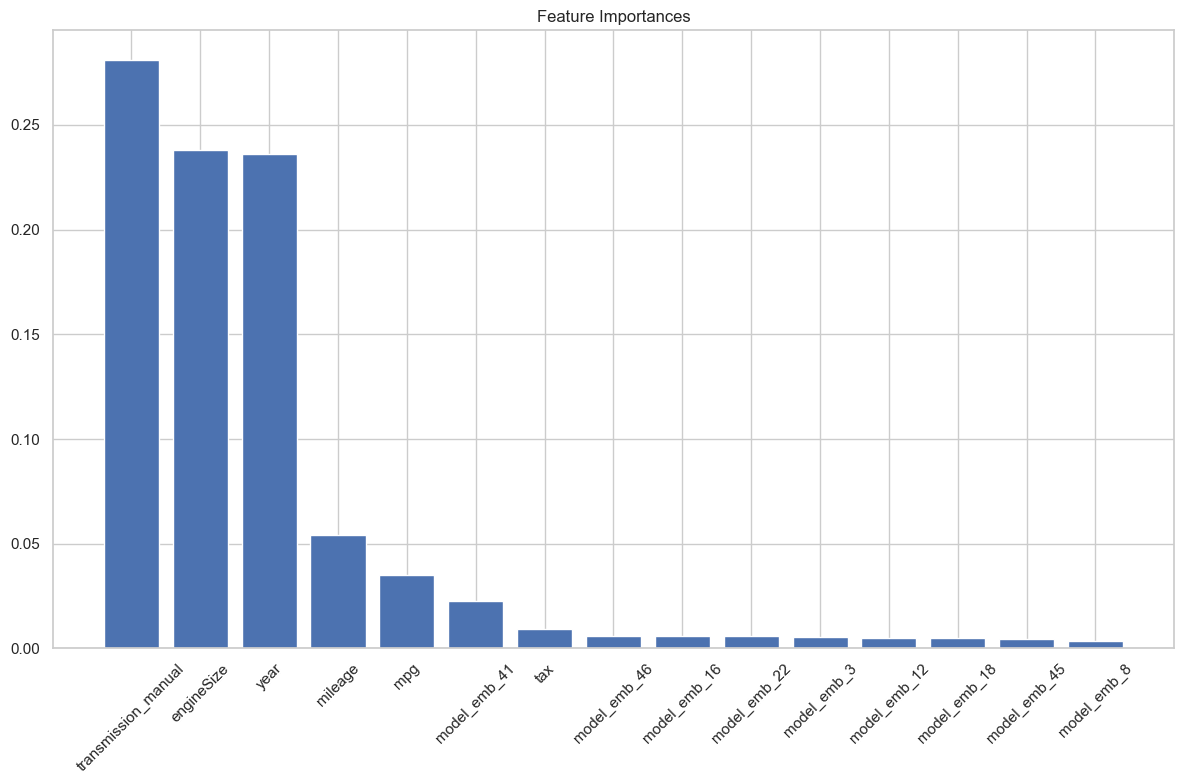


5. Final predictions on test data...

FINAL TEST PREDICTIONS SUMMARY
Training samples used: 75973
Test predictions made: 12764
Predicted price range: €10728.39 - €99365.14
Average predicted price: €14225.14


In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_val, y_val_actual, dataset_name="Validation"):
    """
    Evaluate model performance and print comprehensive metrics
    """
    # Make predictions
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val_actual, y_val_pred)
    mse = mean_squared_error(y_val_actual, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_actual, y_val_pred)
    
    # Calculate percentage errors
    avg_actual_price = np.mean(y_val_actual)
    mae_percentage = (mae / avg_actual_price) * 100
    rmse_percentage = (rmse / avg_actual_price) * 100
    
    # Print results
    print(f"\n" + "="*60)
    print(f"{dataset_name.upper()} SET RESULTS")
    print("="*60)
    print(f"Mean Absolute Error (MAE): €{mae:.2f}")
    print(f"Root Mean Square Error (RMSE): €{rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Average actual price: €{avg_actual_price:.2f}")
    print(f"MAE as % of average price: {mae_percentage:.1f}%")
    print(f"RMSE as % of average price: {rmse_percentage:.1f}%")
    
    # Additional insights
    print(f"\nPrediction Range: €{y_val_pred.min():.2f} - €{y_val_pred.max():.2f}")
    print(f"Actual Range: €{y_val_actual.min():.2f} - €{y_val_actual.max():.2f}")
    
    return {
        'mae': mae,
        'rmse': rmse, 
        'r2': r2,
        'mae_percentage': mae_percentage,
        'predictions': y_val_pred
    }

def comprehensive_cross_validation(model, X, y, cv=5):
    """
    Comprehensive cross-validation with multiple metrics
    """
    print("Performing comprehensive cross-validation...")
    
    scoring = {
        'mae': 'neg_mean_absolute_error',
        'mse': 'neg_mean_squared_error', 
        'r2': 'r2'
    }
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    # Calculate metrics
    mae_scores = -cv_results['test_mae']
    rmse_scores = np.sqrt(-cv_results['test_mse'])
    r2_scores = cv_results['test_r2']
    
    avg_price = np.mean(y)
    
    print(f"\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    print(f"MAE Scores: {mae_scores}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"R² Scores: {r2_scores}")
    
    print(f"\nAverage MAE: €{mae_scores.mean():.2f} (+/- €{mae_scores.std() * 2:.2f})")
    print(f"Average RMSE: €{rmse_scores.mean():.2f} (+/- €{rmse_scores.std() * 2:.2f})")
    print(f"Average R²: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})")
    print(f"Average price in training: €{avg_price:.2f}")
    print(f"MAE as % of average price: {(mae_scores.mean() / avg_price) * 100:.1f}%")
    print(f"RMSE as % of average price: {(rmse_scores.mean() / avg_price) * 100:.1f}%")
    
    return cv_results

def analyze_feature_importance(model, feature_names):
    """
    Analyze which features are most important for predictions
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print(f"\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    # Print feature ranking
    print("Feature ranking:")
    for i, idx in enumerate(indices[:20]):  # Top 20 features
        print(f"{i+1:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(15), importances[indices[:15]], align="center")
    plt.xticks(range(15), [feature_names[idx] for idx in indices[:15]], rotation=45)
    plt.tight_layout()
    plt.show()

def quick_validation_summary(model, X_train, y_train):
    """Quick validation summary using cross-validation"""
    mae_scores = -cross_val_score(model, X_train, y_train, 
                                cv=5, scoring='neg_mean_absolute_error')
    avg_price = np.mean(y_train)
    
    print(f"\n QUICK VALIDATION SUMMARY")
    print(f"   MAE: €{mae_scores.mean():.2f} (+/- €{mae_scores.std() * 2:.2f})")
    print(f"   Average Price: €{avg_price:.2f}")
    print(f"   Error as % of average price: {(mae_scores.mean() / avg_price) * 100:.1f}%")
    
    return mae_scores.mean()

# Now run the complete evaluation workflow
print("=== COMPREHENSIVE MODEL EVALUATION ===")

# 1. Quick Validation Summary
print("1. Quick validation...")
quick_mae = quick_validation_summary(rf_model, X_train_final, y_train)

# 2. Cross-Validation
print("\n2. Comprehensive cross-validation...")
cv_results = comprehensive_cross_validation(rf_model, X_train_final, y_train, cv=5)

# 3. Internal Validation Split
print("\n3. Internal validation split...")
X_temp, X_val, y_temp, y_val = train_test_split(
    X_train_final, y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"   Training split: {X_temp.shape[0]} samples")
print(f"   Validation split: {X_val.shape[0]} samples")

# Train on training split
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# Evaluate on validation split
val_results = evaluate_model(rf_temp, X_val, y_val, "Internal Validation")

# 4. Feature Importance Analysis
print("\n4. Feature importance analysis...")
# Create feature names for interpretation
feature_names = (
    [f'brand_emb_{i}' for i in range(50)] + 
    [f'model_emb_{i}' for i in range(50)] +
    ['year', 'mileage', 'tax', 'mpg', 'engineSize'] +
    ['transmission_auto', 'transmission_manual', 'transmission_other', 'transmission_semi'] +
    ['fuel_diesel', 'fuel_hybrid', 'fuel_other', 'fuel_petrol']
)

analyze_feature_importance(rf_model, feature_names)

# 5. Final Model Training and Test Predictions
print("\n5. Final predictions on test data...")
# Make sure we use the model trained on ALL data (rf_model) for final predictions
test_predictions = rf_model.predict(X_test_final)

print(f"\n" + "="*60)
print("FINAL TEST PREDICTIONS SUMMARY")
print("="*60)
print(f"Training samples used: {X_train_final.shape[0]}")
print(f"Test predictions made: {len(test_predictions)}")
print(f"Predicted price range: €{test_predictions.min():.2f} - €{test_predictions.max():.2f}")
print(f"Average predicted price: €{test_predictions.mean():.2f}")
